In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from mpl_toolkits.mplot3d import Axes3D

# Función escalón
def step_function(summation):
    return np.sign(summation)

# Predecir la salida de la neurona
def predict(input_data, weights, bias):
    summation = np.dot(input_data, weights) + bias
    return step_function(summation)

# Leer datos desde un archivo CSV
def read_data(file_path):
    data = np.genfromtxt(file_path, delimiter=',')
    inputs = data[:, :-1]
    outputs = data[:, -1]
    return inputs, outputs

# Entrenamiento del perceptrón
def train_perceptron(inputs, outputs, learning_rate, max_epochs, convergence_criterion):
    num_inputs = inputs.shape[1]
    num_patterns = inputs.shape[0]

    # Inicialización de pesos y sesgo de manera aleatoria
    weights = np.random.rand(num_inputs)
    bias = np.random.rand()
    epochs = 0

    while epochs < max_epochs:
        has_converged = True
        for i in range(num_patterns):
            input_pattern = inputs[i]
            target_output = outputs[i]
            predicted_output = np.dot(weights, input_pattern) + bias
            error = target_output - predicted_output

            # Actualización de pesos y sesgo si el error es mayor que el criterio de convergencia
            if abs(error) > convergence_criterion:
                has_converged = False
                weights += learning_rate * error * input_pattern
                bias += learning_rate * error
        # Si converge, se sale del bucle
        if has_converged:
            break
        epochs += 1
    return weights, bias

# Función para probar el perceptrón con nuevos datos
def test_perceptron(inputs, weights, bias):
    predicted_output = np.dot(inputs, weights) + bias
    return np.vectorize(step_function)(predicted_output)


In [2]:
def random_partition(inputs, outputs, train_ratio):
    num_samples = len(inputs)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    train_size = int(train_ratio * num_samples)

    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    inputs_train, outputs_train = inputs[train_indices], outputs[train_indices]
    inputs_test, outputs_test = inputs[test_indices], outputs[test_indices]

    return inputs_train, outputs_train, inputs_test, outputs_test

def stratified_partition(inputs, outputs, train_ratio):
    inputs_train, inputs_test, outputs_train, outputs_test = train_test_split(inputs, outputs, train_size=train_ratio, stratify=outputs)
    return inputs_train, outputs_train, inputs_test, outputs_test

def temporal_partition(inputs, outputs, train_ratio):
    num_samples = len(inputs)
    train_size = int(train_ratio * num_samples)

    inputs_train, outputs_train = inputs[:train_size], outputs[:train_size]
    inputs_test, outputs_test = inputs[train_size:], outputs[train_size:]

    return inputs_train, outputs_train, inputs_test, outputs_test

def kfold_partition(inputs, outputs, train_ratio, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_indices, test_indices = next(kf.split(inputs))

    inputs_train, outputs_train = inputs[train_indices], outputs[train_indices]
    inputs_test, outputs_test = inputs[test_indices], outputs[test_indices]

    return inputs_train, outputs_train, inputs_test, outputs_test

def feature_group_partition(inputs, outputs, train_ratio):
    num_samples = len(inputs)
    train_size = int(train_ratio * num_samples)

    inputs_train, outputs_train = inputs[:train_size], outputs[:train_size]
    inputs_test, outputs_test = inputs[train_size:], outputs[train_size:]

    return inputs_train, outputs_train, inputs_test, outputs_test

In [3]:
def plot_3d_dataset(inputs, outputs, title="Dataset"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    unique_classes = np.unique(outputs)
    colors = plt.cm.Paired(np.linspace(0, 1, len(unique_classes)))

    for i, class_label in enumerate(unique_classes):
        class_indices = np.where(outputs == class_label)
        ax.scatter(inputs[class_indices, 0], inputs[class_indices, 1], inputs[class_indices, 2], label=f'Class {int(class_label)}', c=[colors[i]])

    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_zlabel("Feature 3")
    ax.legend()
    plt.show()

In [4]:
def main():
    datasets = ['/content/spheres2d10.csv', '/content/spheres2d50.csv', '/content/spheres2d70.csv']

    # Seleccionar aleatoriamente dos datasets adicionales de la lista existente
    additional_datasets = random.sample(datasets, 2)
    datasets += additional_datasets

    for i, dataset in enumerate(datasets):
        inputs, outputs = read_data(dataset)

        print(f'\nDataset {i + 1}: {dataset}')

        train_ratio = float(input("Ingrese el valor de train_ratio (por ejemplo, 0.8 para un 80%): "))

        techniques_to_test = [random_partition, stratified_partition, temporal_partition, kfold_partition, feature_group_partition]

        print("Técnicas disponibles:")
        for idx, technique in enumerate(techniques_to_test, start=1):
            print(f"{idx}. {technique.__name__}")

        selected_techniques = [techniques_to_test[int(choice) - 1] for choice in input("Seleccione las técnicas de partición (por ejemplo, 1, 2, 3, 4, 5): ").split()]

        for selected_technique in selected_techniques:
            # Aplica la técnica de partición y obtiene los conjuntos de entrenamiento y prueba
            inputs_train, outputs_train, inputs_test, outputs_test = selected_technique(inputs, outputs, train_ratio=train_ratio)

            # Entrenar el perceptrón
            trained_weights, trained_bias = train_perceptron(inputs_train, outputs_train, learning_rate=0.1, max_epochs=30, convergence_criterion=0.01)

            # Probar el perceptrón
            predicted_outputs = test_perceptron(inputs_test, trained_weights, trained_bias)

            # Evaluar el modelo y mostrar métricas
            accuracy = accuracy_score(outputs_test, predicted_outputs)
            precision = precision_score(outputs_test, predicted_outputs, average='weighted')
            recall = recall_score(outputs_test, predicted_outputs, average='weighted')
            f1 = f1_score(outputs_test, predicted_outputs, average='weighted')

            print(f'Técnica: {selected_technique.__name__} - Dataset: {dataset}')
            print(f'Accuracy: {accuracy}')
            print(f'Precision: {precision}')
            print(f'Recall: {recall}')
            print(f'F1 Score: {f1}')
            print('\n')

            # Preguntar al usuario si desea graficar los resultados
            plot_choice = input("¿Desea graficar los resultados en 3D? (Sí/No): ").lower()

            if plot_choice == "si" or plot_choice == "sí":
                plot_3d_dataset(inputs_test, predicted_outputs, title=f"Conjunto de Datos 3D - Técnica: {selected_technique.__name__}")


Dataset 1: /content/spheres2d10.csv
Ingrese el valor de train_ratio (por ejemplo, 0.8 para un 80%): 0.8
Técnicas disponibles:
1. random_partition
2. stratified_partition
3. temporal_partition
4. kfold_partition
5. feature_group_partition
Seleccione las técnicas de partición (por ejemplo, 1, 2, 3, 4, 5): 1
Técnica: random_partition - Dataset: /content/spheres2d10.csv
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


¿Desea graficar los resultados en 3D? (Sí/No): si


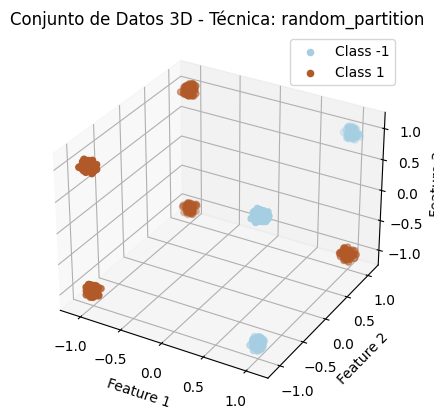


Dataset 2: /content/spheres2d50.csv
Ingrese el valor de train_ratio (por ejemplo, 0.8 para un 80%): 0.8
Técnicas disponibles:
1. random_partition
2. stratified_partition
3. temporal_partition
4. kfold_partition
5. feature_group_partition
Seleccione las técnicas de partición (por ejemplo, 1, 2, 3, 4, 5): 2
Técnica: stratified_partition - Dataset: /content/spheres2d50.csv
Accuracy: 0.895
Precision: 0.9183086680761099
Recall: 0.895
F1 Score: 0.8967984413969564


¿Desea graficar los resultados en 3D? (Sí/No): si


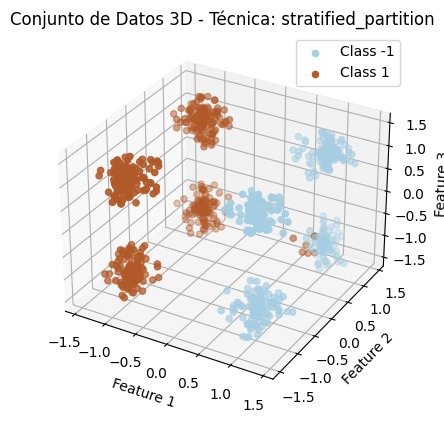


Dataset 3: /content/spheres2d70.csv
Ingrese el valor de train_ratio (por ejemplo, 0.8 para un 80%): 0.8
Técnicas disponibles:
1. random_partition
2. stratified_partition
3. temporal_partition
4. kfold_partition
5. feature_group_partition
Seleccione las técnicas de partición (por ejemplo, 1, 2, 3, 4, 5): 3
Técnica: temporal_partition - Dataset: /content/spheres2d70.csv
Accuracy: 0.925
Precision: 0.9286431112078979
Recall: 0.925
F1 Score: 0.9236992336976624


¿Desea graficar los resultados en 3D? (Sí/No): Si


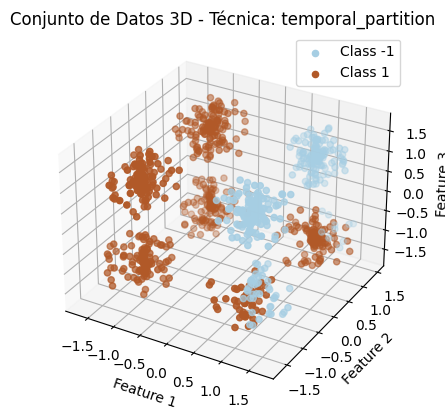


Dataset 4: /content/spheres2d70.csv
Ingrese el valor de train_ratio (por ejemplo, 0.8 para un 80%): 0.8
Técnicas disponibles:
1. random_partition
2. stratified_partition
3. temporal_partition
4. kfold_partition
5. feature_group_partition
Seleccione las técnicas de partición (por ejemplo, 1, 2, 3, 4, 5): 4
Técnica: kfold_partition - Dataset: /content/spheres2d70.csv
Accuracy: 0.866
Precision: 0.9017689243027889
Recall: 0.866
F1 Score: 0.8683744074865222


¿Desea graficar los resultados en 3D? (Sí/No): si


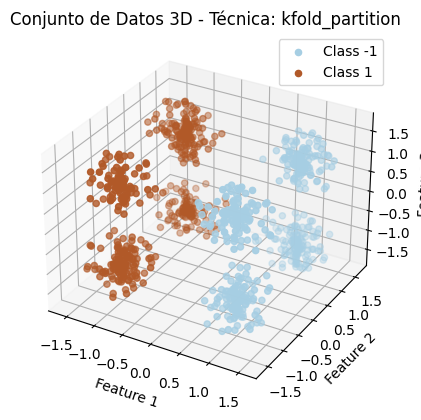


Dataset 5: /content/spheres2d50.csv
Ingrese el valor de train_ratio (por ejemplo, 0.8 para un 80%): 0.8
Técnicas disponibles:
1. random_partition
2. stratified_partition
3. temporal_partition
4. kfold_partition
5. feature_group_partition
Seleccione las técnicas de partición (por ejemplo, 1, 2, 3, 4, 5): 5
Técnica: feature_group_partition - Dataset: /content/spheres2d50.csv
Accuracy: 0.873
Precision: 0.905258
Recall: 0.873
F1 Score: 0.8750819629809192


¿Desea graficar los resultados en 3D? (Sí/No): si


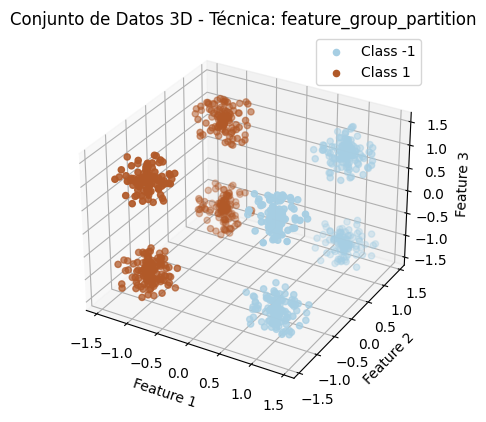

In [6]:
if __name__ == "__main__":
    main()